# Qidfa I, Ahmed et al.

### define process data function

In [1]:
def compare_brine_concentrations(dataframe, raw_data, export_path, elemental_masses, literature_cf, original_concentrations = True):
    from chempy.properties.water_density_tanaka_2001 import water_density
    from sigfig import round
    from scipy.constants import milli, kilo
    from matplotlib import pyplot
    import matplotlib

    pandas.set_option('display.max_columns', None)
    pandas.set_option('display.max_rows', None)
    print('raw_data')
    display(raw_data)
    print('processed_data')
    display(dataframe)

    # final effluent concentrations
    final_cf = raw_data['mass_H2O'].iloc[0] / raw_data['mass_H2O'].iloc[-1]
    last_row = dataframe.iloc[-1]
    print('literature_cf', literature_cf)
    print('final_cf', final_cf)

    # feed concentrations
    water_density = water_density()/kilo
    solution_description = 'Ahmed'
    custom_water_parameters = {
        'element': {
            'Ca': {
                'concentration (ppm)':464,
                'reference': ''
            },
            'Mg': {
                'concentration (ppm)':1640,
                'reference':''
            },
            'Na': {
                'concentration (ppm)':11900,
                'reference':''
            },
            'Sr': {
                'concentration (ppm)':4.56,
                'reference':''
            },
            'Cl': {
                'concentration (ppm)':23149,
                'reference':''
            },
            'S(6)': {
                'concentration (ppm)':2787,
                'reference':''
            },
            'Fe': {
                'concentration (ppm)':0.22,
                'reference':''
            },
            'K': {
                'concentration (ppm)':574,
                'reference':''
            }
        },
        'Alkalinity': {
            'value': 111,
            'reference': ''
        }
    }

    def make_molal(elements):
        molals = {}
        for element in elements:
            original_element = element
            element = re.sub('(?:\(\d\))', '', element)
            mass = elemental_masses[element]/milli
            if type(elements[original_element]) is dict:
                ppm_conc = elements[original_element]['concentration (ppm)']
            else:
                ppm_conc = elements[original_element]
            molal_conc = ppm_conc / water_density / mass
            molals[original_element] = float(molal_conc)
            
        return molals

    molals = make_molal(custom_water_parameters['element'])
    literature_molals = make_molal(literature_final_conc)
    
    # final effluent CF for each element
    cfs = {}
    diff_list = []
    labels = []
    for element, final_conc in last_row.iteritems():
        element = re.search('([A-Z][a-z]?(?:\(\d\))?(?=\(mol\/kgw\)))', element).group()
        cfs[element] = {}
        initial_conc = molals[element]

        if original_concentrations:
            if element in literature_elemental_cfs:
                cfs[element]['cf'] = float(final_conc) / initial_conc
                diff = ((cfs[element]['cf'] - literature_elemental_cfs[element]) / literature_elemental_cfs[element]) * 100
                labels.append(element)
                diff_list.append(diff)
                cfs[element]['% diff'] = diff
                
        elif not original_concentrations:
            if element in literature_final_conc:
                predicted_conc = initial_conc * literature_cf
                literature_conc = literature_molals[element]
                diff = ((predicted_conc - literature_conc) / literature_conc) * 100
                labels.append(element)
                diff_list.append(diff)
                cfs[element]['% diff'] = diff

    # define a bar graph of CF error 
    print(cfs)
    labels.append('CF')
    total_cf_error = ((final_cf - literature_cf) / literature_cf * 100)
    diff_list.append(total_cf_error)
    min_diff = min(diff_list) - 5
    max_diff = max(diff_list) + 5

    pyplot.rc("figure", figsize = (17, 9), dpi=400)
    pyplot.rc('axes', titlesize=22, labelsize=22)
    pyplot.rc('xtick', labelsize=20)
    pyplot.rc('ytick', labelsize=20)
    pyplot.rc('legend', title_fontsize=25, fontsize=23)
    pyplot.rc('legend', title_fontsize=25, fontsize=23)
    figure, ax = pyplot.subplots()
    bar_graph = ax.bar(labels, diff_list)
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('%-error')
    ax.set_ylim(min_diff, max_diff)
    ax.set_xlabel('Element')
    ax.set_title('Elemental difference of ROSSpy from Qifda I, Ahmed et al.')
    diff_list = [round(value, 2) for value in diff_list]
    ax.bar_label(bar_graph, diff_list, fontsize=20)
    figure.savefig(export_path)

### Experimental conditions

In [2]:
from scipy.constants import nano, milli, day, hour
from chemicals import periodic_table
import os, re

elemental_masses = {}
for element in periodic_table:
    elemental_masses[element.symbol] = element.MW
    
def average(some_list):
    return sum(some_list)/ len(some_list)


# general parameters
database_selection = 'pitzer'
simulation = 'brine'
simulation_time = 275

# run the ROSS model
%run ../../../rosspy/ro.py
ross = ROSSPkg(database_selection, verbose = False)
# import rosspy
# ross = rosspy.ROSSPkg(database_selection, verbose = False)

# water parameters
solution_description = 'Ahmed'
water_characteristics = {
    'element': {
        'Ca': {
            'concentration (ppm)':464,
            'reference': ''
        },
        'Mg': {
            'concentration (ppm)':1640,
            'reference':''
        },
        'Na': {
            'concentration (ppm)':11900,
            'reference':''
        },
        'Sr': {
            'concentration (ppm)':4.56,
            'reference':''
        },
        'Cl': {
            'concentration (ppm)':23149,
            'reference':''
        },
        'S(6)': {
            'concentration (ppm)':2787,
            'reference':''
        },
        'Fe': {
            'concentration (ppm)':0.22,
            'reference':''
        },
        'K': {
            'concentration (ppm)':574,
            'reference':''
        }
    },
    'Alkalinity': {
        'value': 111,
        'reference': ''
    }
}

# literature final effluent concentrations 
literature_final_conc = {
    'Ca': 617,
    'Mg': 2150,
    'Na': 15100,
    'Sr': 7.19,
    'Fe': 0.33,
    'Cl': 30540,
    'K': 767,
    'S(6)': 3931
}
literature_elemental_cfs = {}
for element in literature_final_conc:
    true_element = re.search('([A-Z][a-z]?)', element).group()
    literature_elemental_cfs[element] = literature_final_conc[element]/(water_characteristics['element'][element]['concentration (ppm)'])
literature_cf = average([(literature_elemental_cfs[element]) for element in literature_elemental_cfs])


# Execute through all_time


Estimated completion in 9 seconds: 2022-11-24 15:05:48.393265 local time.
run_time (s): 8.7790762


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


raw_data


,sim,state,soln,dist_x,time,step,pH,pe,reaction,temp(C),Alk(eq/kgw),mu,mass_H2O,charge(eq),Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw),Anhydrite,d_Anhydrite,Aragonite,d_Aragonite,Arcanite,d_Arcanite,Artinite,d_Artinite,Bischofite,d_Bischofite,Bloedite,d_Bloedite,Brucite,d_Brucite,Burkeite,d_Burkeite,Calcite,d_Calcite,Carnallite,d_Carnallite,Celestite,d_Celestite,Dolomite,d_Dolomite,Epsomite,d_Epsomite,Gaylussite,d_Gaylussite,Glaserite,d_Glaserite,Glauberite,d_Glauberite,Goergeyite,d_Goergeyite,Gypsum,d_Gypsum,Halite,d_Halite,Hexahydrite,d_Hexahydrite,Huntite,d_Huntite,Kainite,d_Kainite,Kieserite,d_Kieserite,Labile_S,d_Labile_S,Leonhardite,d_Leonhardite,Leonite,d_Leonite,Magnesite,d_Magnesite,MgCl2_2H2O,d_MgCl2_2H2O,MgCl2_4H2O,d_MgCl2_4H2O,Mirabilite,d_Mirabilite,Natron,d_Natron,Nesquehonite,d_Nesquehonite,Pentahydrite,d_Pentahydrite,Pirssonite,d_Pirssonite,Polyhalite,d_Polyhalite,Portlandite,d_Portlandite,Schoenite,d_Schoenite,Sylvite,d_Sylvite,Syngenite,d_Syngenite,Thenardite,d_Thenardite,si_Anhydrite,si_Aragonite,si_Arcanite,si_Artinite,si_Bischofite,si_Bloedite,si_Brucite,si_Burkeite,si_Calcite,si_Carnallite,si_Celestite,si_Dolomite,si_Epsomite,si_Gaylussite,si_Glaserite,si_Glauberite,si_Goergeyite,si_Gypsum,si_Halite,si_Hexahydrite,si_Huntite,si_Kainite,si_Kieserite,si_Labile_S,si_Leonhardite,si_Leonite,si_Magnesite,si_MgCl2_2H2O,si_MgCl2_4H2O,si_Mirabilite,si_Natron,si_Nesquehonite,si_Pentahydrite,si_Pirssonite,si_Polyhalite,si_Portlandite,si_Schoenite,si_Sylvite,si_Syngenite,si_Thenardite
3,1,transp,12,0.973667,0.000000,0,7.000000,4.0,12.466606,25.0,1.216293e-09,1.006454e-07,13.171724,-1.602067e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
4,1,transp,12,0.973667,2.991110,1,7.000046,4.0,12.466606,25.0,1.237738e-09,1.006455e-07,12.943514,-1.602067e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
5,1,transp,12,0.973667,5.982220,2,7.000097,4.0,12.466606,25.0,1.261053e-09,1.006455e-07,12.704198,-1.602067e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

processed_data


,Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw)
Time (s),,,,,,,,
29.9,1.262248e-14,7.381107e-14,5.666023e-13,NaN,NaN,NaN,NaN,NaN
32.9,2.304094e-08,1.348705e-07,1.035534e-06,1.041152e-10,0.000001,5.804020e-08,7.880893e-12,2.937018e-08
35.9,1.640899e-02,9.628016e-02,7.396017e-01,7.436143e-05,0.932965,4.145362e-02,5.628711e-06,2.097684e-02
38.9,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
41.9,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
44.9,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
47.9,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
50.8,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
53.8,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02


literature_cf 1.3815465672518445
final_cf 1.370796422899502
{'Ca': {'cf': 1.4131433888506204, '% diff': 6.2720473949251065}, 'Mg': {'cf': 1.4226721103755302, '% diff': 8.520105163528811}, 'Na': {'cf': 1.4246290732335105, '% diff': 12.27209252634951}, 'Sr': {'cf': 1.4246309322722268, '% diff': -9.647885241149465}, 'Cl': {'cf': 1.4246309322722117, '% diff': 7.985531929172976}, 'S(6)': {'cf': 0.4755245549145212, '% diff': -66.28626470244797}, 'Fe': {'cf': 1.4245799132046932, '% diff': -5.028005786353784}, 'K': {'cf': 1.4246309322722186, '% diff': 6.615144083996541}}


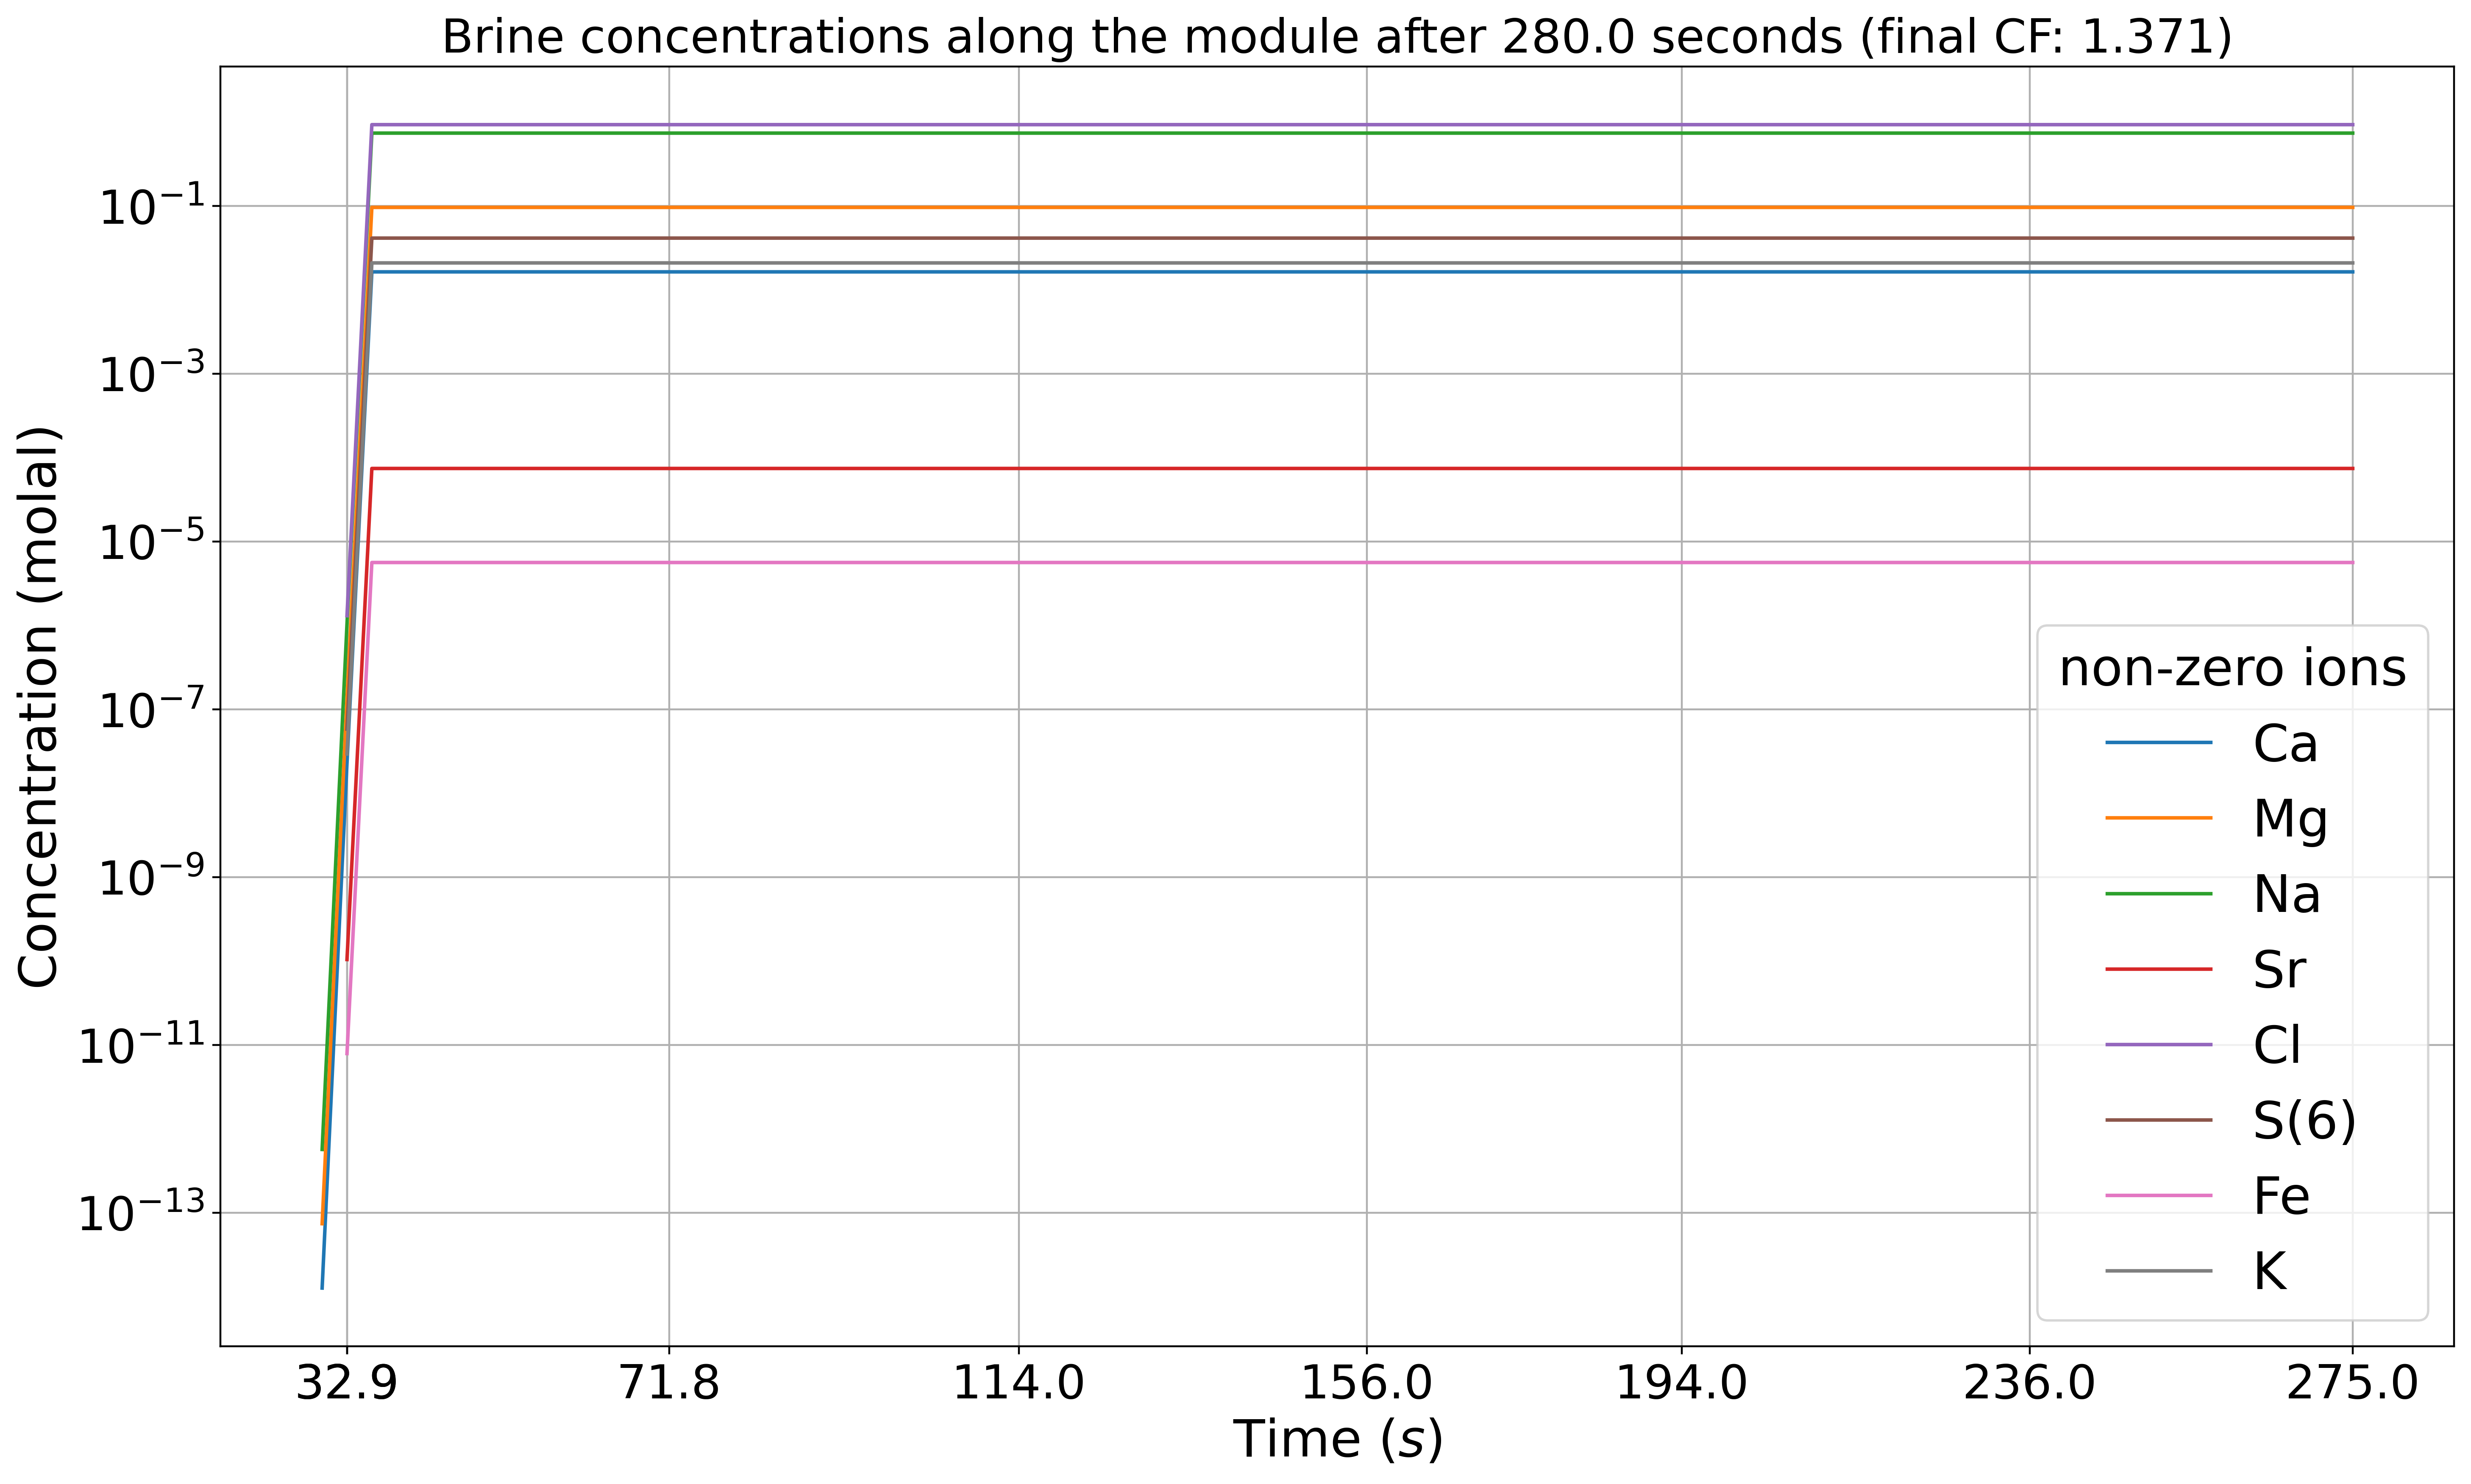

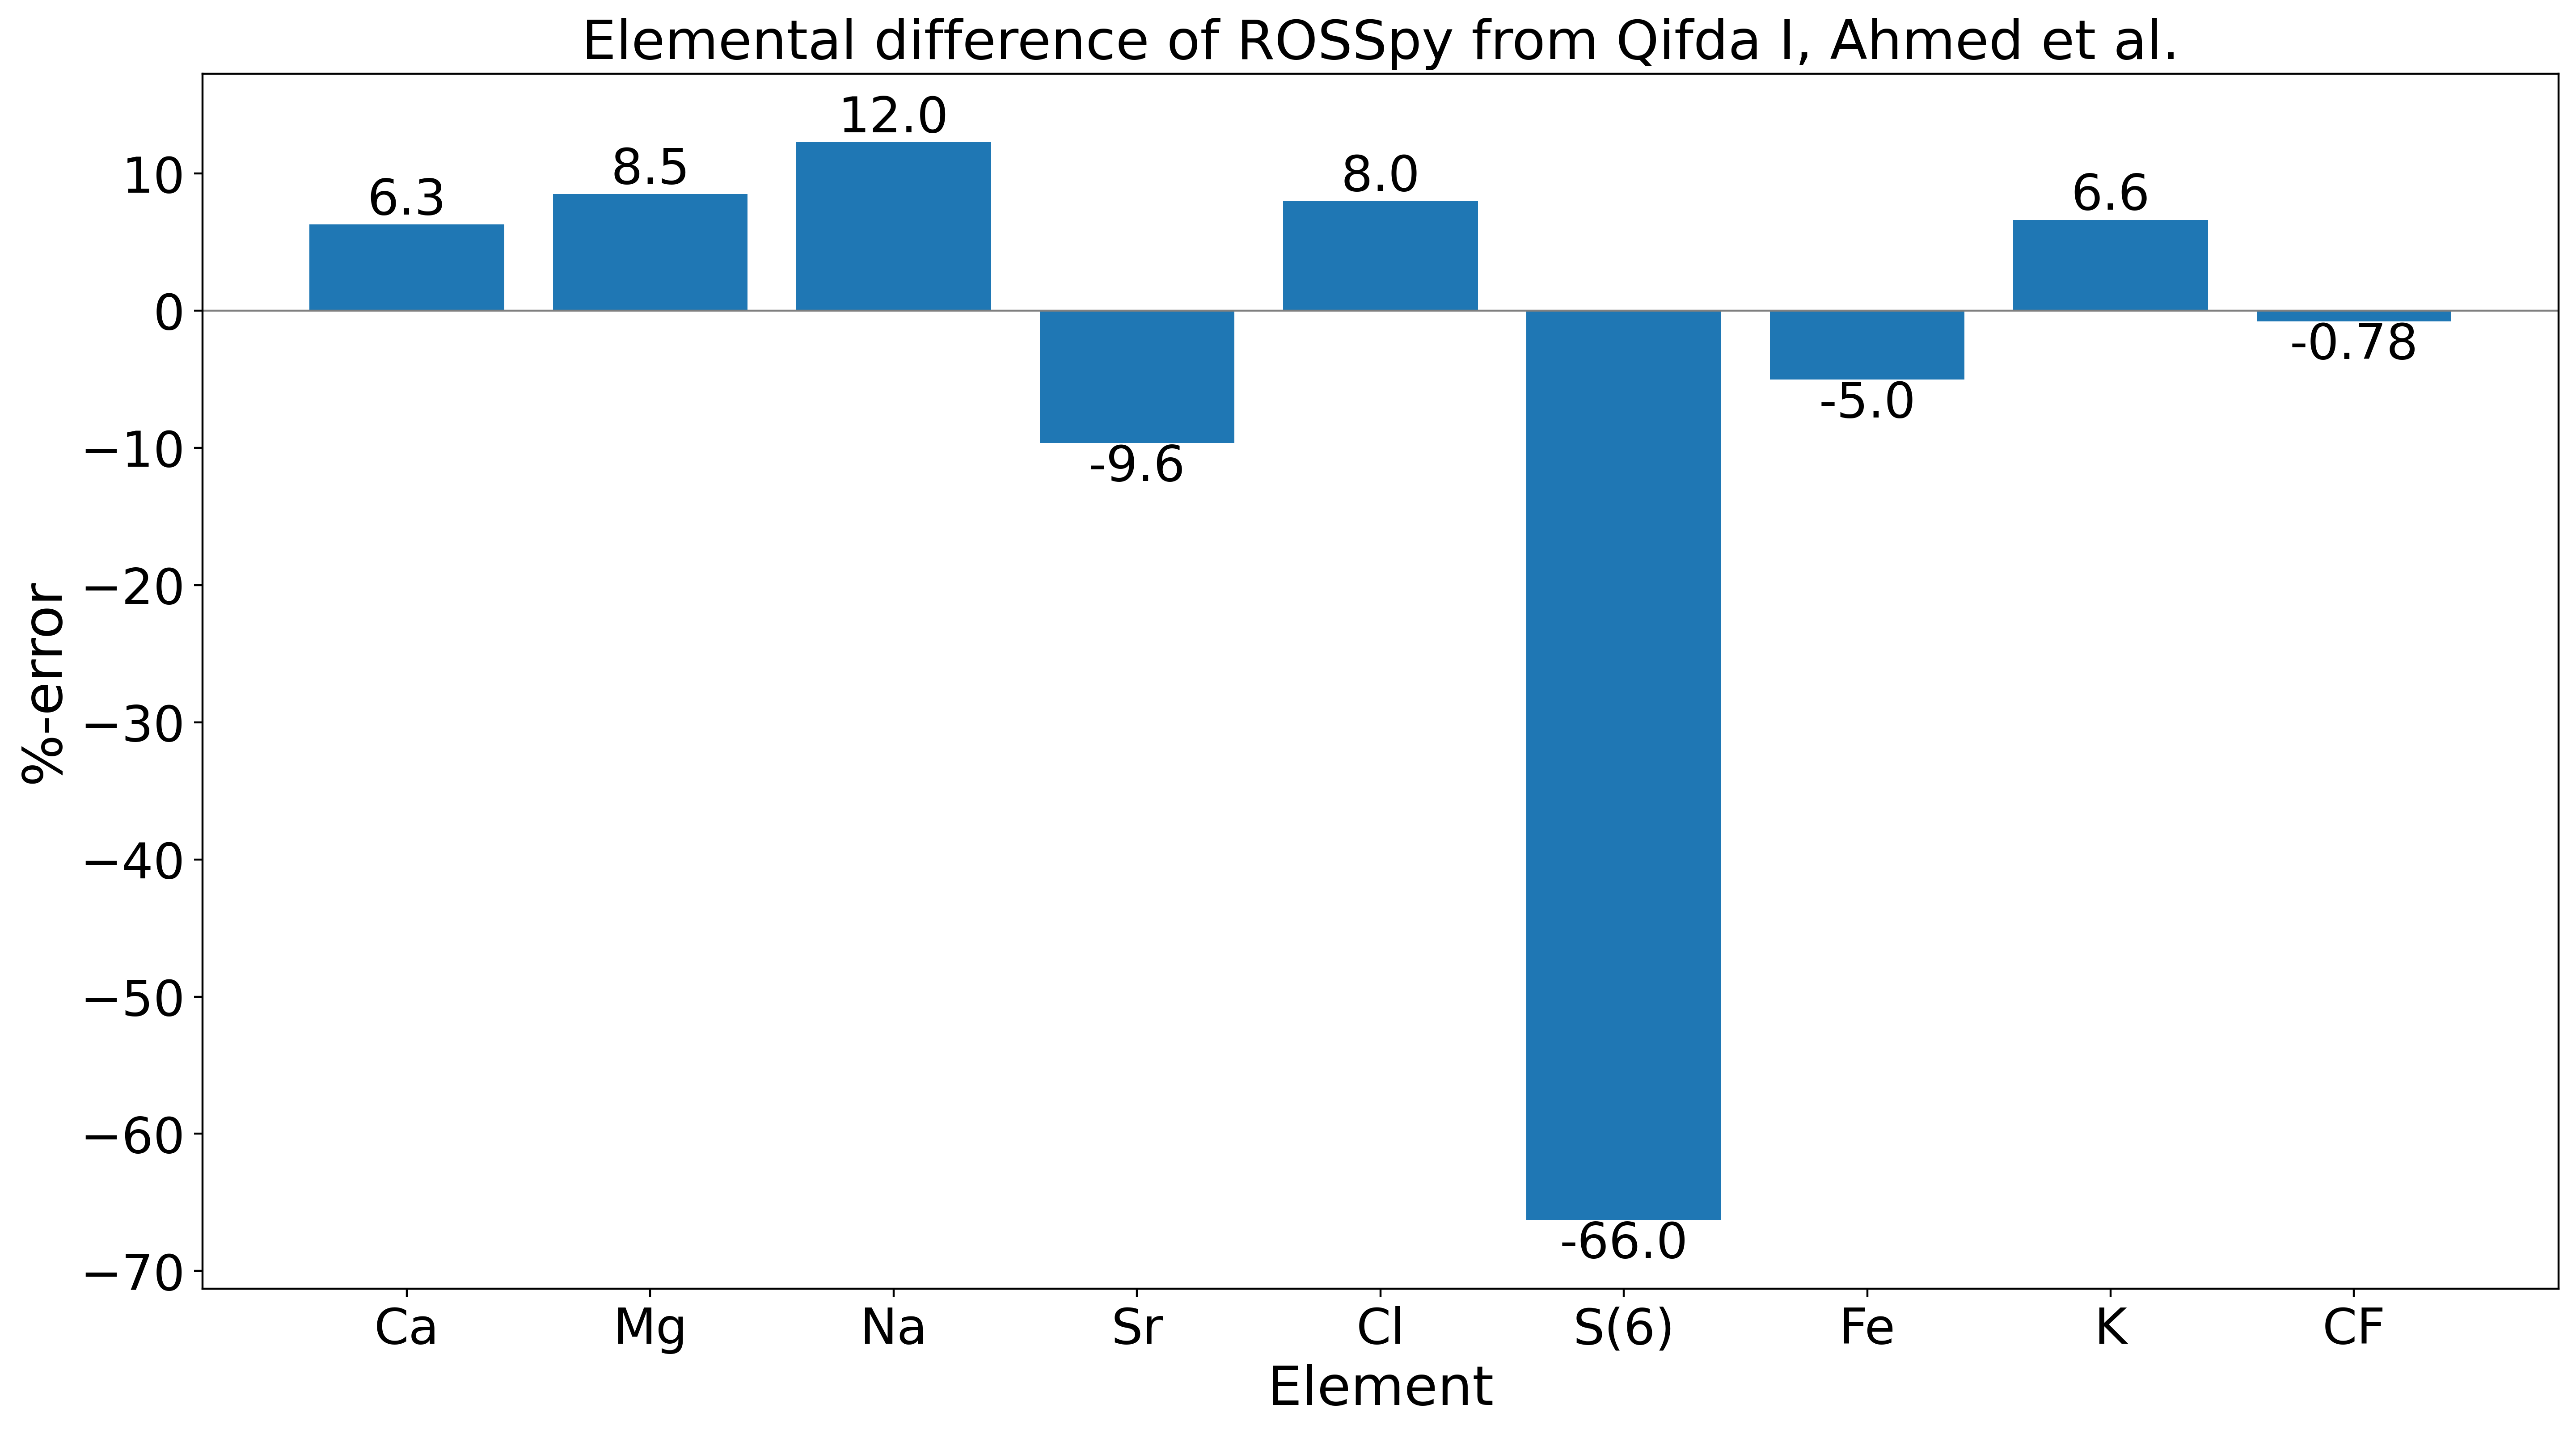

In [3]:
%run ../../../rosspy/ro.py
simulation_name = 'PHREEQ_ionic_concentrations'
simulation_perspective = 'all_time'

# create the input file
ross = ROSSPkg(database_selection, simulation, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name, export_format="eps")


# process and export the data
export_path = os.path.join(ross.simulation_path, 'Ahmed_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, elemental_masses, literature_cf)

# Execute through all_time, with improved predictions


Estimated completion in 9 seconds: 2022-11-24 15:06:01.524018 local time.
run_time (s): 7.6032443


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


raw_data


,sim,state,soln,dist_x,time,step,pH,pe,reaction,temp(C),Alk(eq/kgw),mu,mass_H2O,charge(eq),Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw),Anhydrite,d_Anhydrite,Aragonite,d_Aragonite,Arcanite,d_Arcanite,Artinite,d_Artinite,Bischofite,d_Bischofite,Bloedite,d_Bloedite,Brucite,d_Brucite,Burkeite,d_Burkeite,Calcite,d_Calcite,Carnallite,d_Carnallite,Celestite,d_Celestite,Dolomite,d_Dolomite,Epsomite,d_Epsomite,Gaylussite,d_Gaylussite,Glaserite,d_Glaserite,Glauberite,d_Glauberite,Goergeyite,d_Goergeyite,Gypsum,d_Gypsum,Halite,d_Halite,Hexahydrite,d_Hexahydrite,Huntite,d_Huntite,Kainite,d_Kainite,Kieserite,d_Kieserite,Labile_S,d_Labile_S,Leonhardite,d_Leonhardite,Leonite,d_Leonite,Magnesite,d_Magnesite,MgCl2_2H2O,d_MgCl2_2H2O,MgCl2_4H2O,d_MgCl2_4H2O,Mirabilite,d_Mirabilite,Natron,d_Natron,Nesquehonite,d_Nesquehonite,Pentahydrite,d_Pentahydrite,Pirssonite,d_Pirssonite,Polyhalite,d_Polyhalite,Portlandite,d_Portlandite,Schoenite,d_Schoenite,Sylvite,d_Sylvite,Syngenite,d_Syngenite,Thenardite,d_Thenardite,si_Anhydrite,si_Aragonite,si_Arcanite,si_Artinite,si_Bischofite,si_Bloedite,si_Brucite,si_Burkeite,si_Calcite,si_Carnallite,si_Celestite,si_Dolomite,si_Epsomite,si_Gaylussite,si_Glaserite,si_Glauberite,si_Goergeyite,si_Gypsum,si_Halite,si_Hexahydrite,si_Huntite,si_Kainite,si_Kieserite,si_Labile_S,si_Leonhardite,si_Leonite,si_Magnesite,si_MgCl2_2H2O,si_MgCl2_4H2O,si_Mirabilite,si_Natron,si_Nesquehonite,si_Pentahydrite,si_Pirssonite,si_Polyhalite,si_Portlandite,si_Schoenite,si_Sylvite,si_Syngenite,si_Thenardite
3,1,transp,12,0.973667,0.000000,0,7.000000,4.0,12.466606,25.0,1.216293e-09,1.006454e-07,13.171724,-1.602067e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
4,1,transp,12,0.973667,2.991110,1,7.000046,4.0,12.466606,25.0,1.237738e-09,1.006455e-07,12.943514,-1.602067e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
5,1,transp,12,0.973667,5.982220,2,7.000097,4.0,12.466606,25.0,1.261053e-09,1.006455e-07,12.704198,-1.602067e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

processed_data


,Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw)
Time (s),,,,,,,,
29.9,1.262248e-14,7.381107e-14,5.666023e-13,NaN,NaN,NaN,NaN,NaN
32.9,2.304094e-08,1.348705e-07,1.035534e-06,1.041152e-10,0.000001,5.804020e-08,7.880893e-12,2.937018e-08
35.9,1.640899e-02,9.628016e-02,7.396017e-01,7.436143e-05,0.932965,4.145362e-02,5.628711e-06,2.097684e-02
38.9,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
41.9,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
44.9,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
47.9,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
50.8,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02
53.8,1.640902e-02,9.628029e-02,7.396027e-01,7.436153e-05,0.932966,4.145367e-02,5.628719e-06,2.097687e-02


literature_cf 1.3815465672518445
final_cf 1.370796422899502
{'Ca': {'% diff': 3.8958844740446983}, 'Mg': {'% diff': 5.383086990373269}, 'Na': {'% diff': 8.876848677463245}, 'Sr': {'% diff': -12.380356791816254}, 'Cl': {'% diff': 4.71978220469206}, 'S(6)': {'% diff': -2.0511248300460156}, 'Fe': {'% diff': -7.896895516543714}, 'K': {'% diff': 3.3908382793427325}}


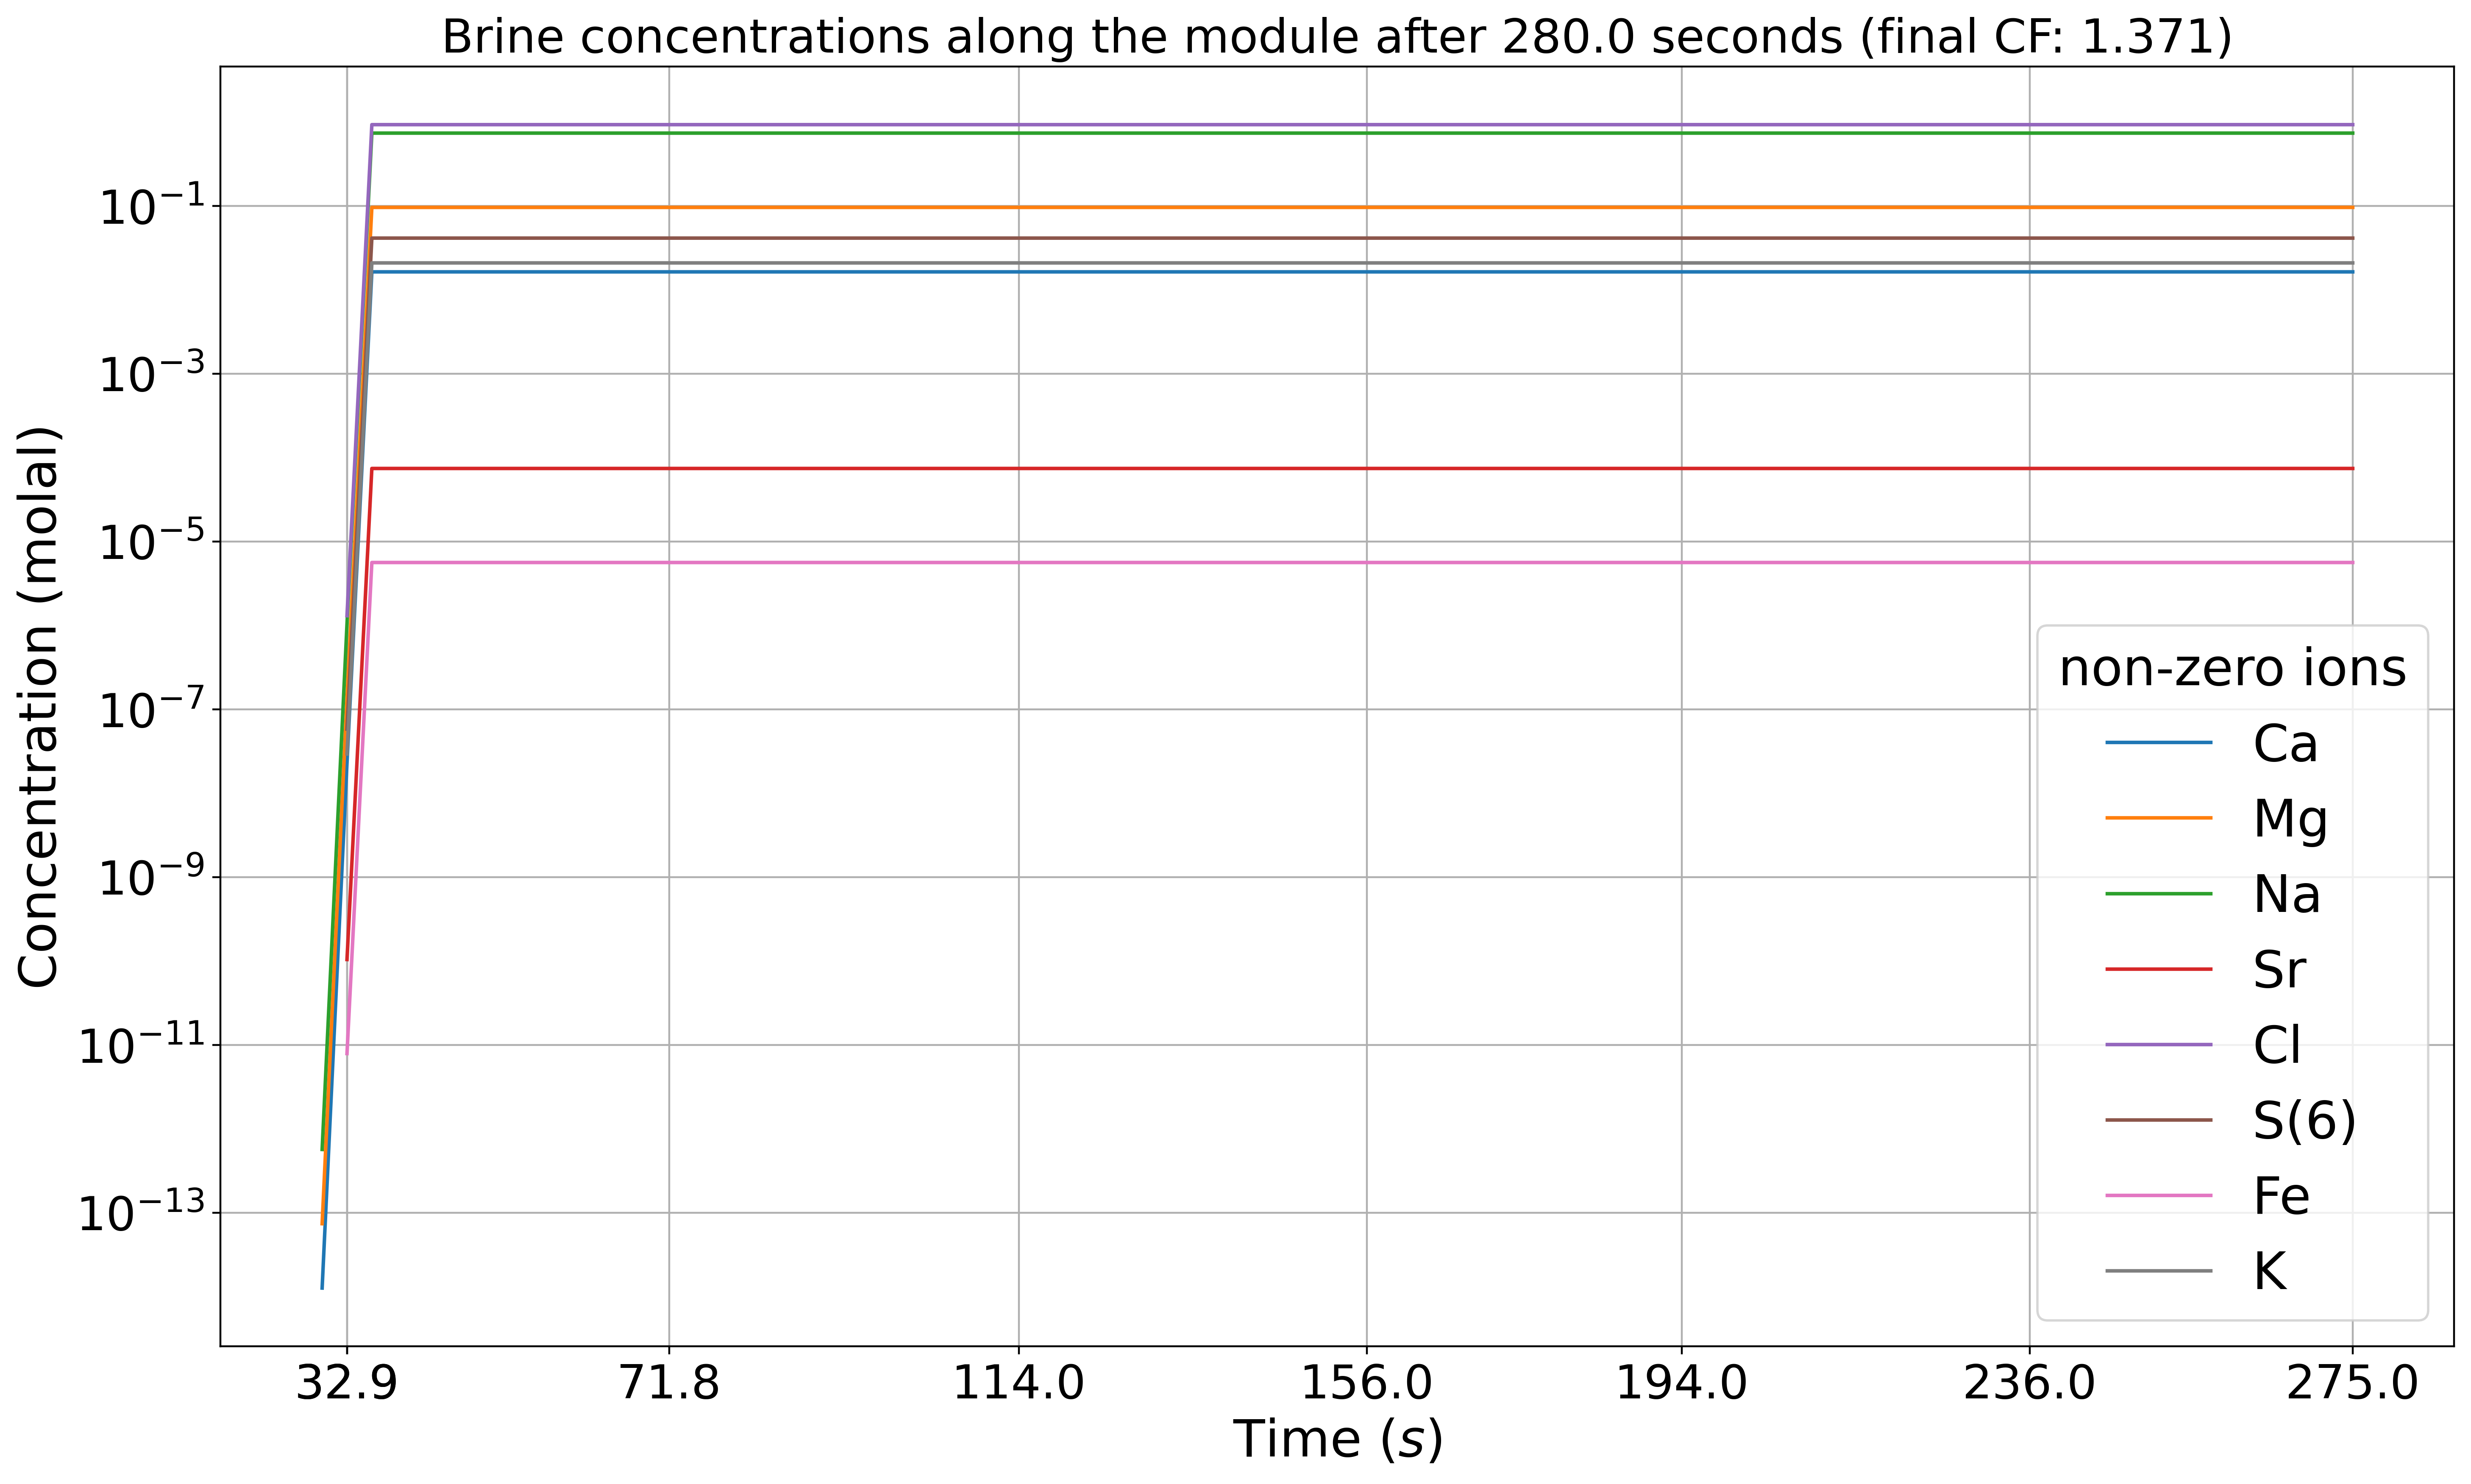

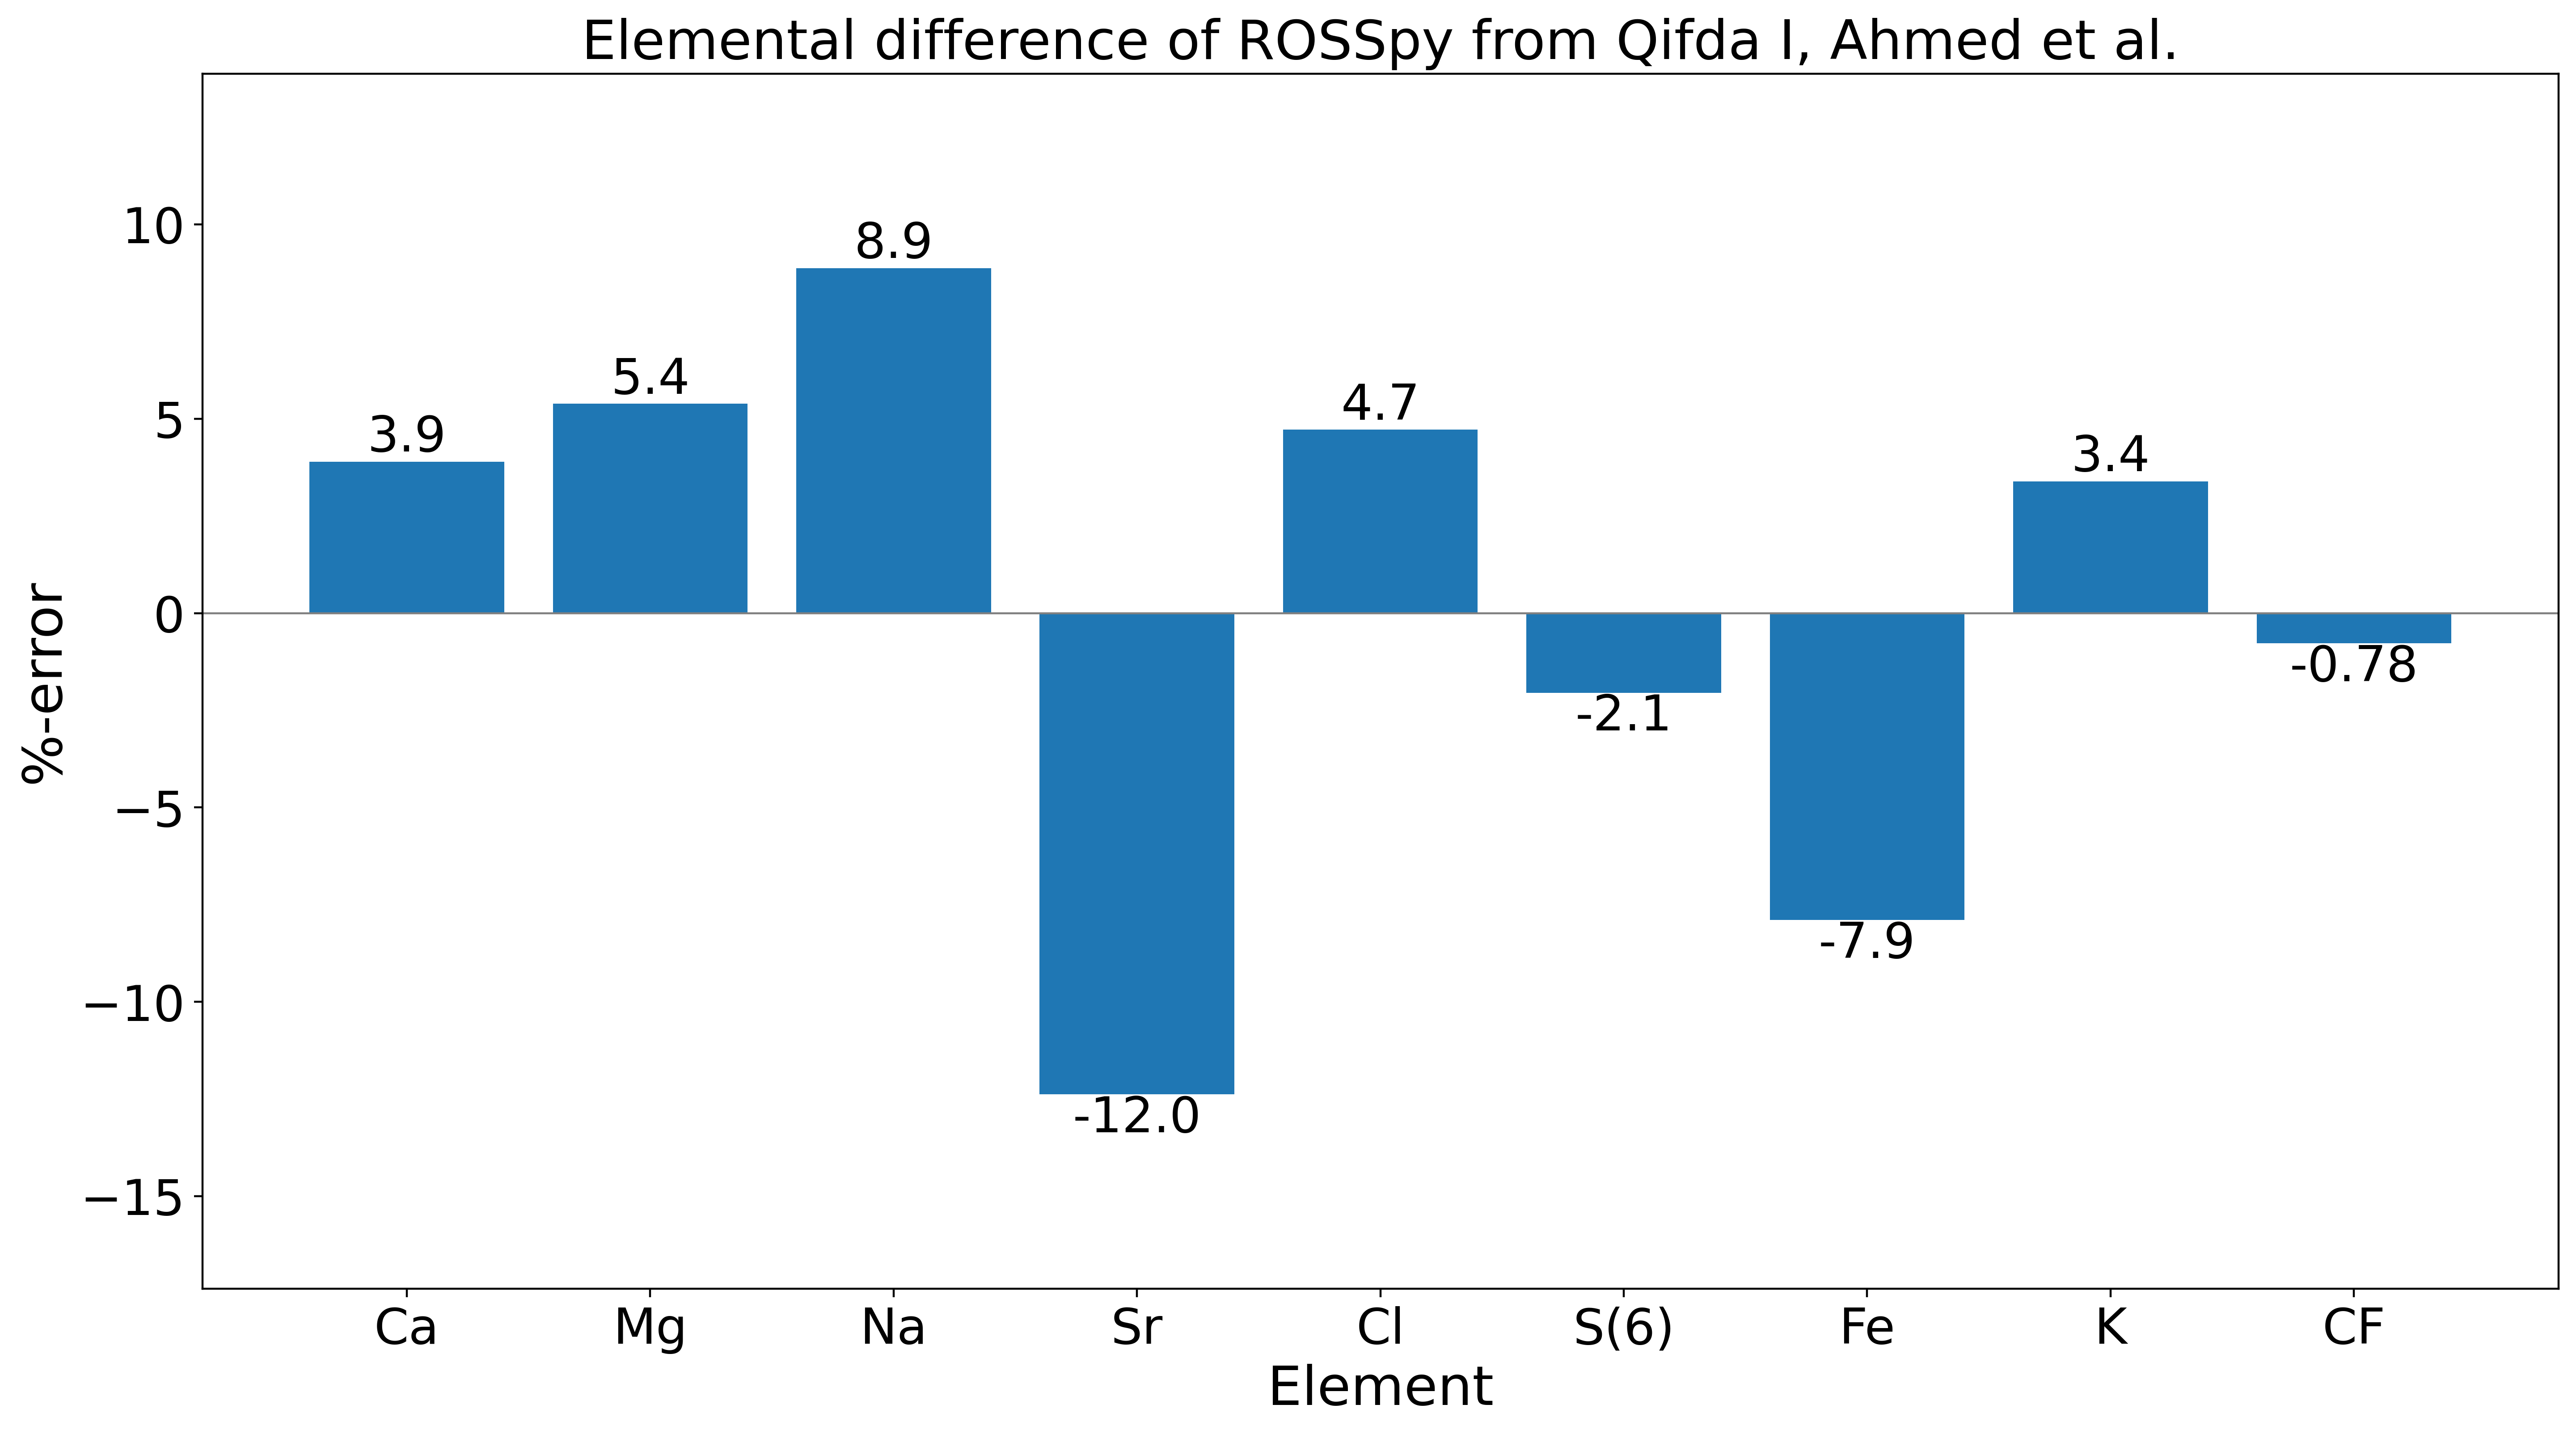

In [4]:
%run ../../../rosspy/ro.py
simulation_perspective = 'all_time'
simulation_name = 'improved_ionic_concentrations'

# create the input file
ross = ROSSPkg(database_selection, simulation, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name, export_format="eps")

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Ahmed_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, elemental_masses, literature_cf, False)

## Execute a single module over all_distance


Estimated completion in 9 seconds: 2022-11-24 15:06:12.802650 local time.
run_time (s): 7.554884699999999


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


raw_data


,sim,state,soln,dist_x,time,step,pH,pe,reaction,temp(C),Alk(eq/kgw),mu,mass_H2O,charge(eq),Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw),Anhydrite,d_Anhydrite,Aragonite,d_Aragonite,Arcanite,d_Arcanite,Artinite,d_Artinite,Bischofite,d_Bischofite,Bloedite,d_Bloedite,Brucite,d_Brucite,Burkeite,d_Burkeite,Calcite,d_Calcite,Carnallite,d_Carnallite,Celestite,d_Celestite,Dolomite,d_Dolomite,Epsomite,d_Epsomite,Gaylussite,d_Gaylussite,Glaserite,d_Glaserite,Glauberite,d_Glauberite,Goergeyite,d_Goergeyite,Gypsum,d_Gypsum,Halite,d_Halite,Hexahydrite,d_Hexahydrite,Huntite,d_Huntite,Kainite,d_Kainite,Kieserite,d_Kieserite,Labile_S,d_Labile_S,Leonhardite,d_Leonhardite,Leonite,d_Leonite,Magnesite,d_Magnesite,MgCl2_2H2O,d_MgCl2_2H2O,MgCl2_4H2O,d_MgCl2_4H2O,Mirabilite,d_Mirabilite,Natron,d_Natron,Nesquehonite,d_Nesquehonite,Pentahydrite,d_Pentahydrite,Pirssonite,d_Pirssonite,Polyhalite,d_Polyhalite,Portlandite,d_Portlandite,Schoenite,d_Schoenite,Sylvite,d_Sylvite,Syngenite,d_Syngenite,Thenardite,d_Thenardite,si_Anhydrite,si_Aragonite,si_Arcanite,si_Artinite,si_Bischofite,si_Bloedite,si_Brucite,si_Burkeite,si_Calcite,si_Carnallite,si_Celestite,si_Dolomite,si_Epsomite,si_Gaylussite,si_Glaserite,si_Glauberite,si_Goergeyite,si_Gypsum,si_Halite,si_Hexahydrite,si_Huntite,si_Kainite,si_Kieserite,si_Labile_S,si_Leonhardite,si_Leonite,si_Magnesite,si_MgCl2_2H2O,si_MgCl2_4H2O,si_Mirabilite,si_Natron,si_Nesquehonite,si_Pentahydrite,si_Pirssonite,si_Polyhalite,si_Portlandite,si_Schoenite,si_Sylvite,si_Syngenite,si_Thenardite
3,1,transp,1,0.042333,0.000000,0,7.000000,4.0,22.530653,25.0,1.216293e-09,1.006454e-07,13.171724,-1.602067e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
4,1,transp,2,0.127000,0.000000,0,7.000000,4.0,21.183567,25.0,1.216293e-09,1.006454e-07,13.171724,-1.602067e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
5,1,transp,3,0.211667,0.000000,0,7.000000,4.0,19.953786,25.0,1.216293e-09,1.006454e-07,13.171724,-1.602067e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

processed_data


,Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw)
Distance (m),,,,,,,,
0.0423,0.012273,0.071761,0.550859,0.000055,0.694877,0.030875,0.000004,0.015624
0.1270,0.012650,0.073991,0.568018,0.000057,0.716522,0.031837,0.000004,0.016110
0.2120,0.013027,0.076221,0.585177,0.000059,0.738167,0.032798,0.000004,0.016597
0.2960,0.013403,0.078451,0.602336,0.000061,0.759812,0.033760,0.000005,0.017084
0.3810,0.013780,0.080680,0.619495,0.000062,0.781457,0.034722,0.000005,0.017570
0.4660,0.014156,0.082910,0.636653,0.000064,0.803102,0.035684,0.000005,0.018057
0.5500,0.014532,0.085139,0.653812,0.000066,0.824746,0.036645,0.000005,0.018544
0.6350,0.014908,0.087367,0.670970,0.000067,0.846390,0.037607,0.000005,0.019030
0.7200,0.015283,0.089596,0.688128,0.000069,0.868034,0.038569,0.000005,0.019517


literature_cf 1.3815465672518445
final_cf 1.370796422899502
{'Ca': {'% diff': 3.8958844740446983}, 'Mg': {'% diff': 5.383086990373269}, 'Na': {'% diff': 8.876848677463245}, 'Sr': {'% diff': -12.380356791816254}, 'Cl': {'% diff': 4.71978220469206}, 'S(6)': {'% diff': -2.0511248300460156}, 'Fe': {'% diff': -7.896895516543714}, 'K': {'% diff': 3.3908382793427325}}


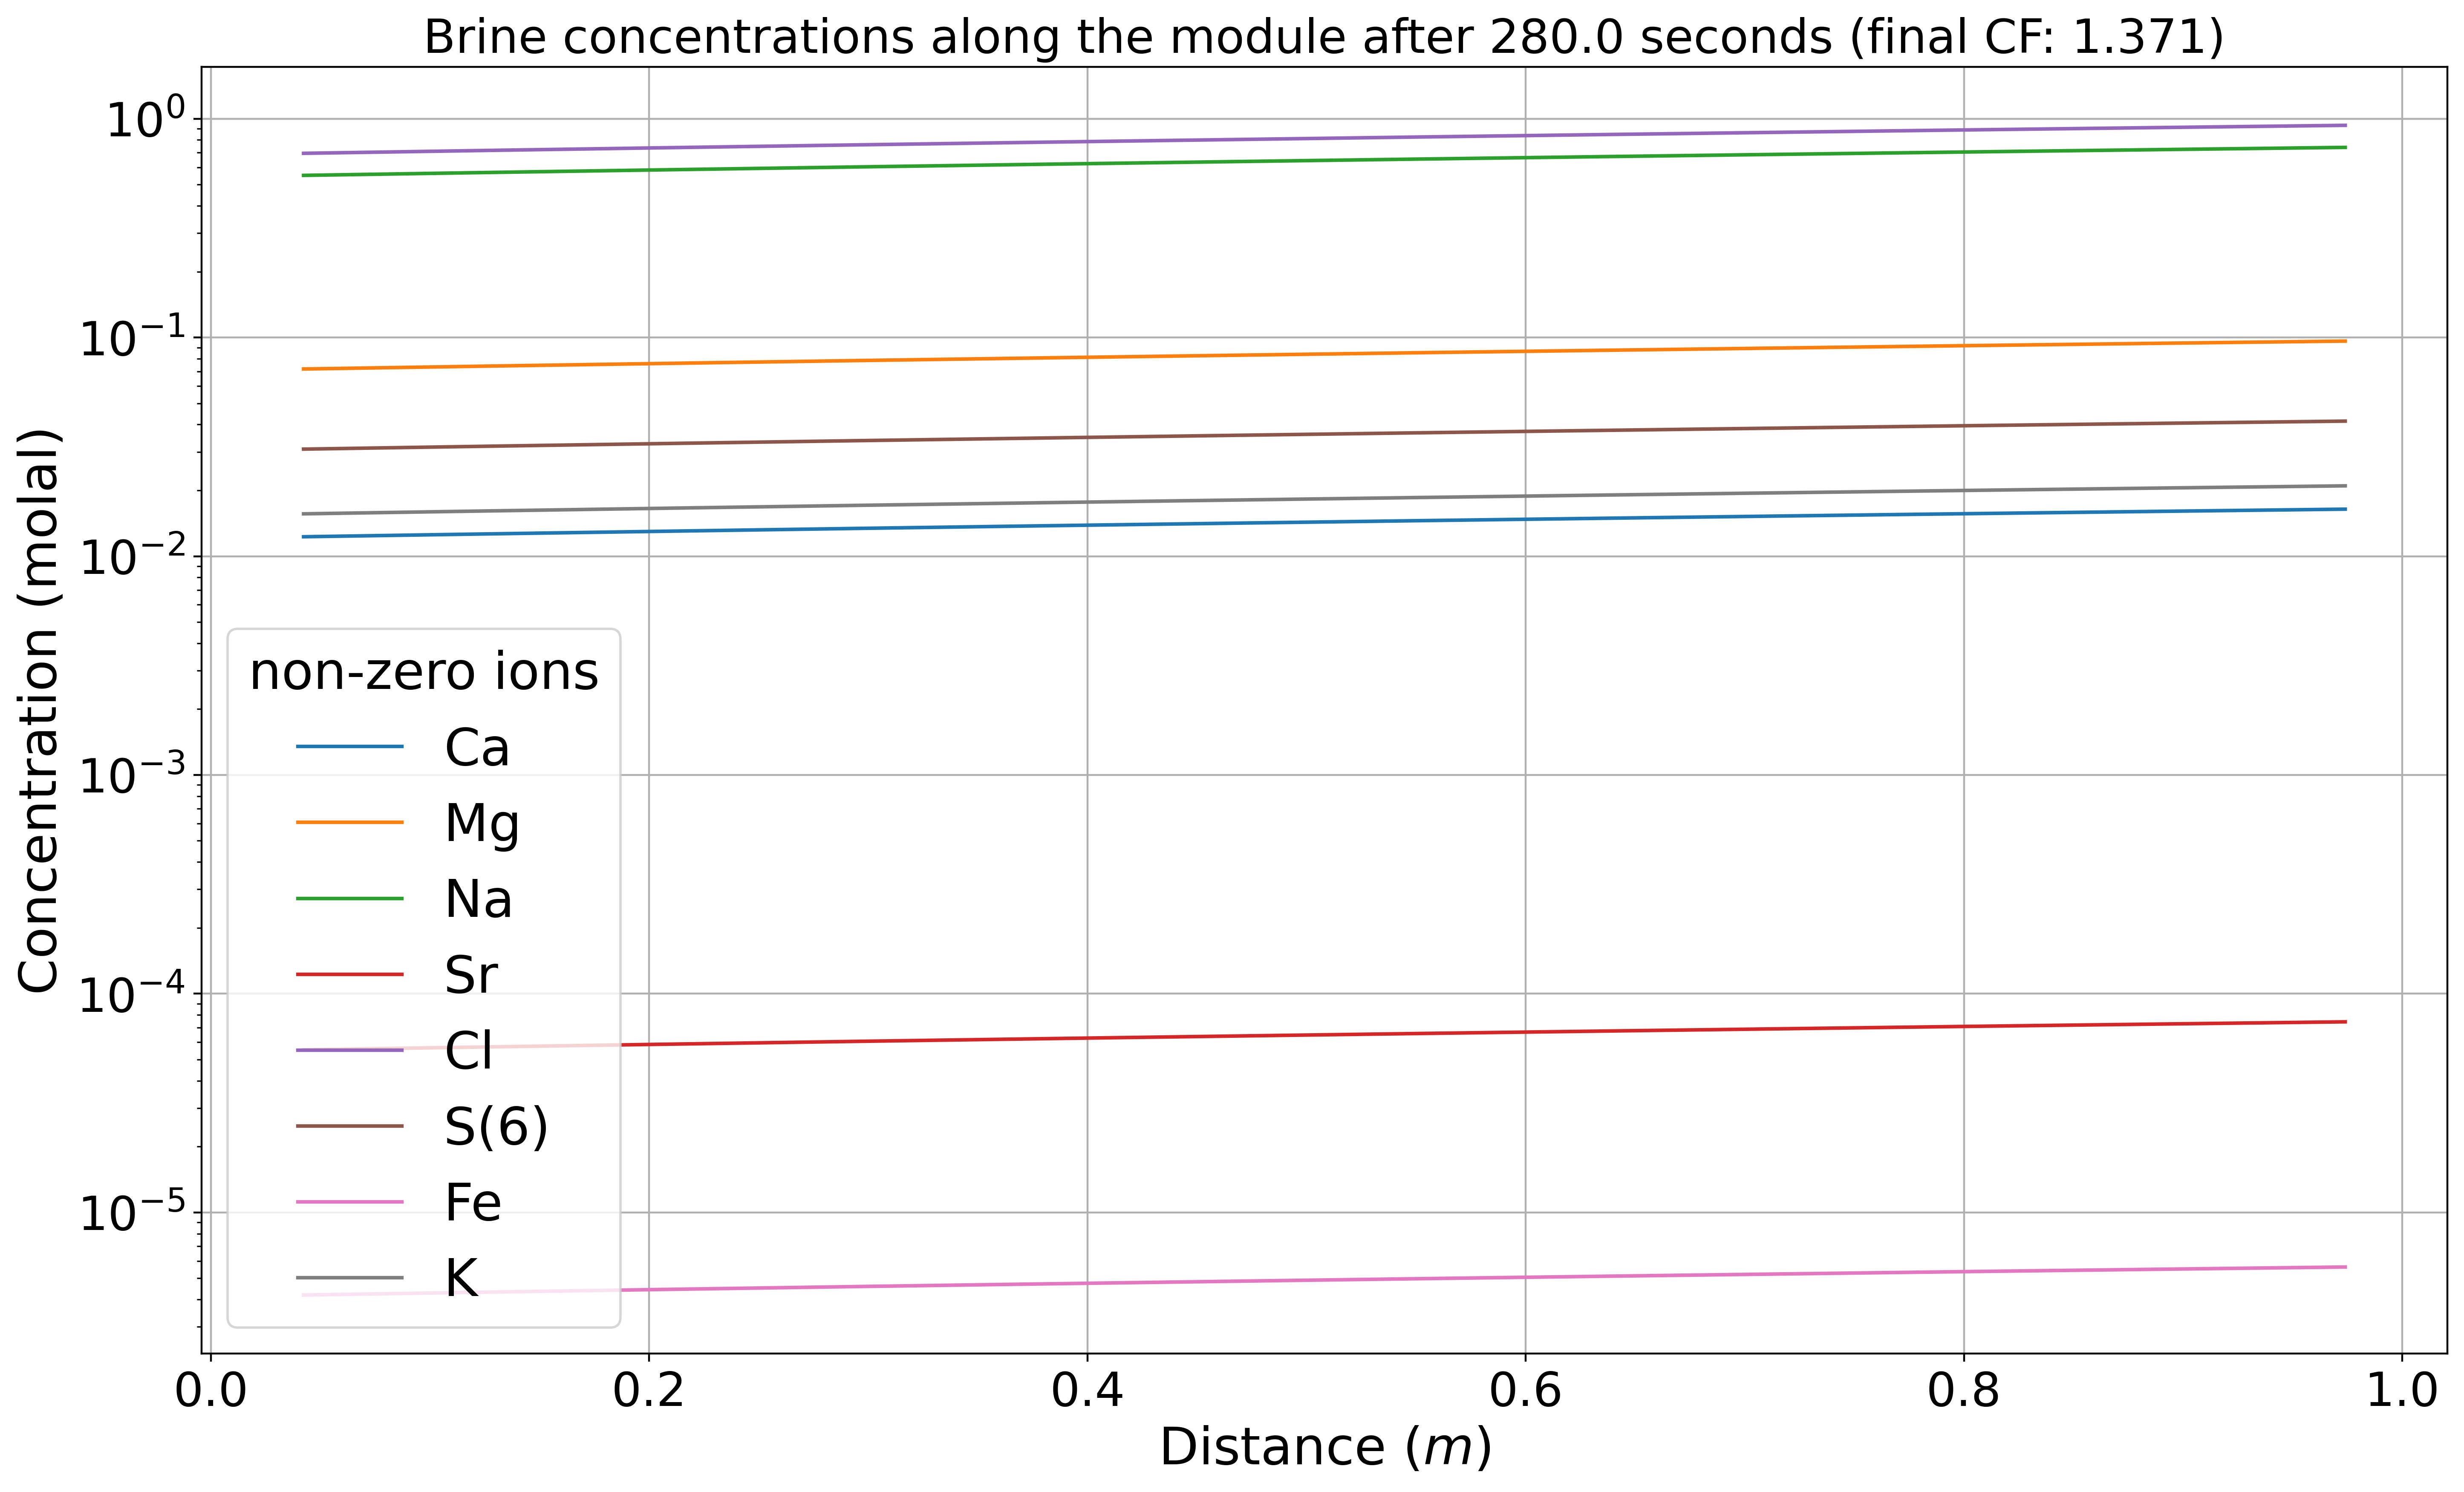

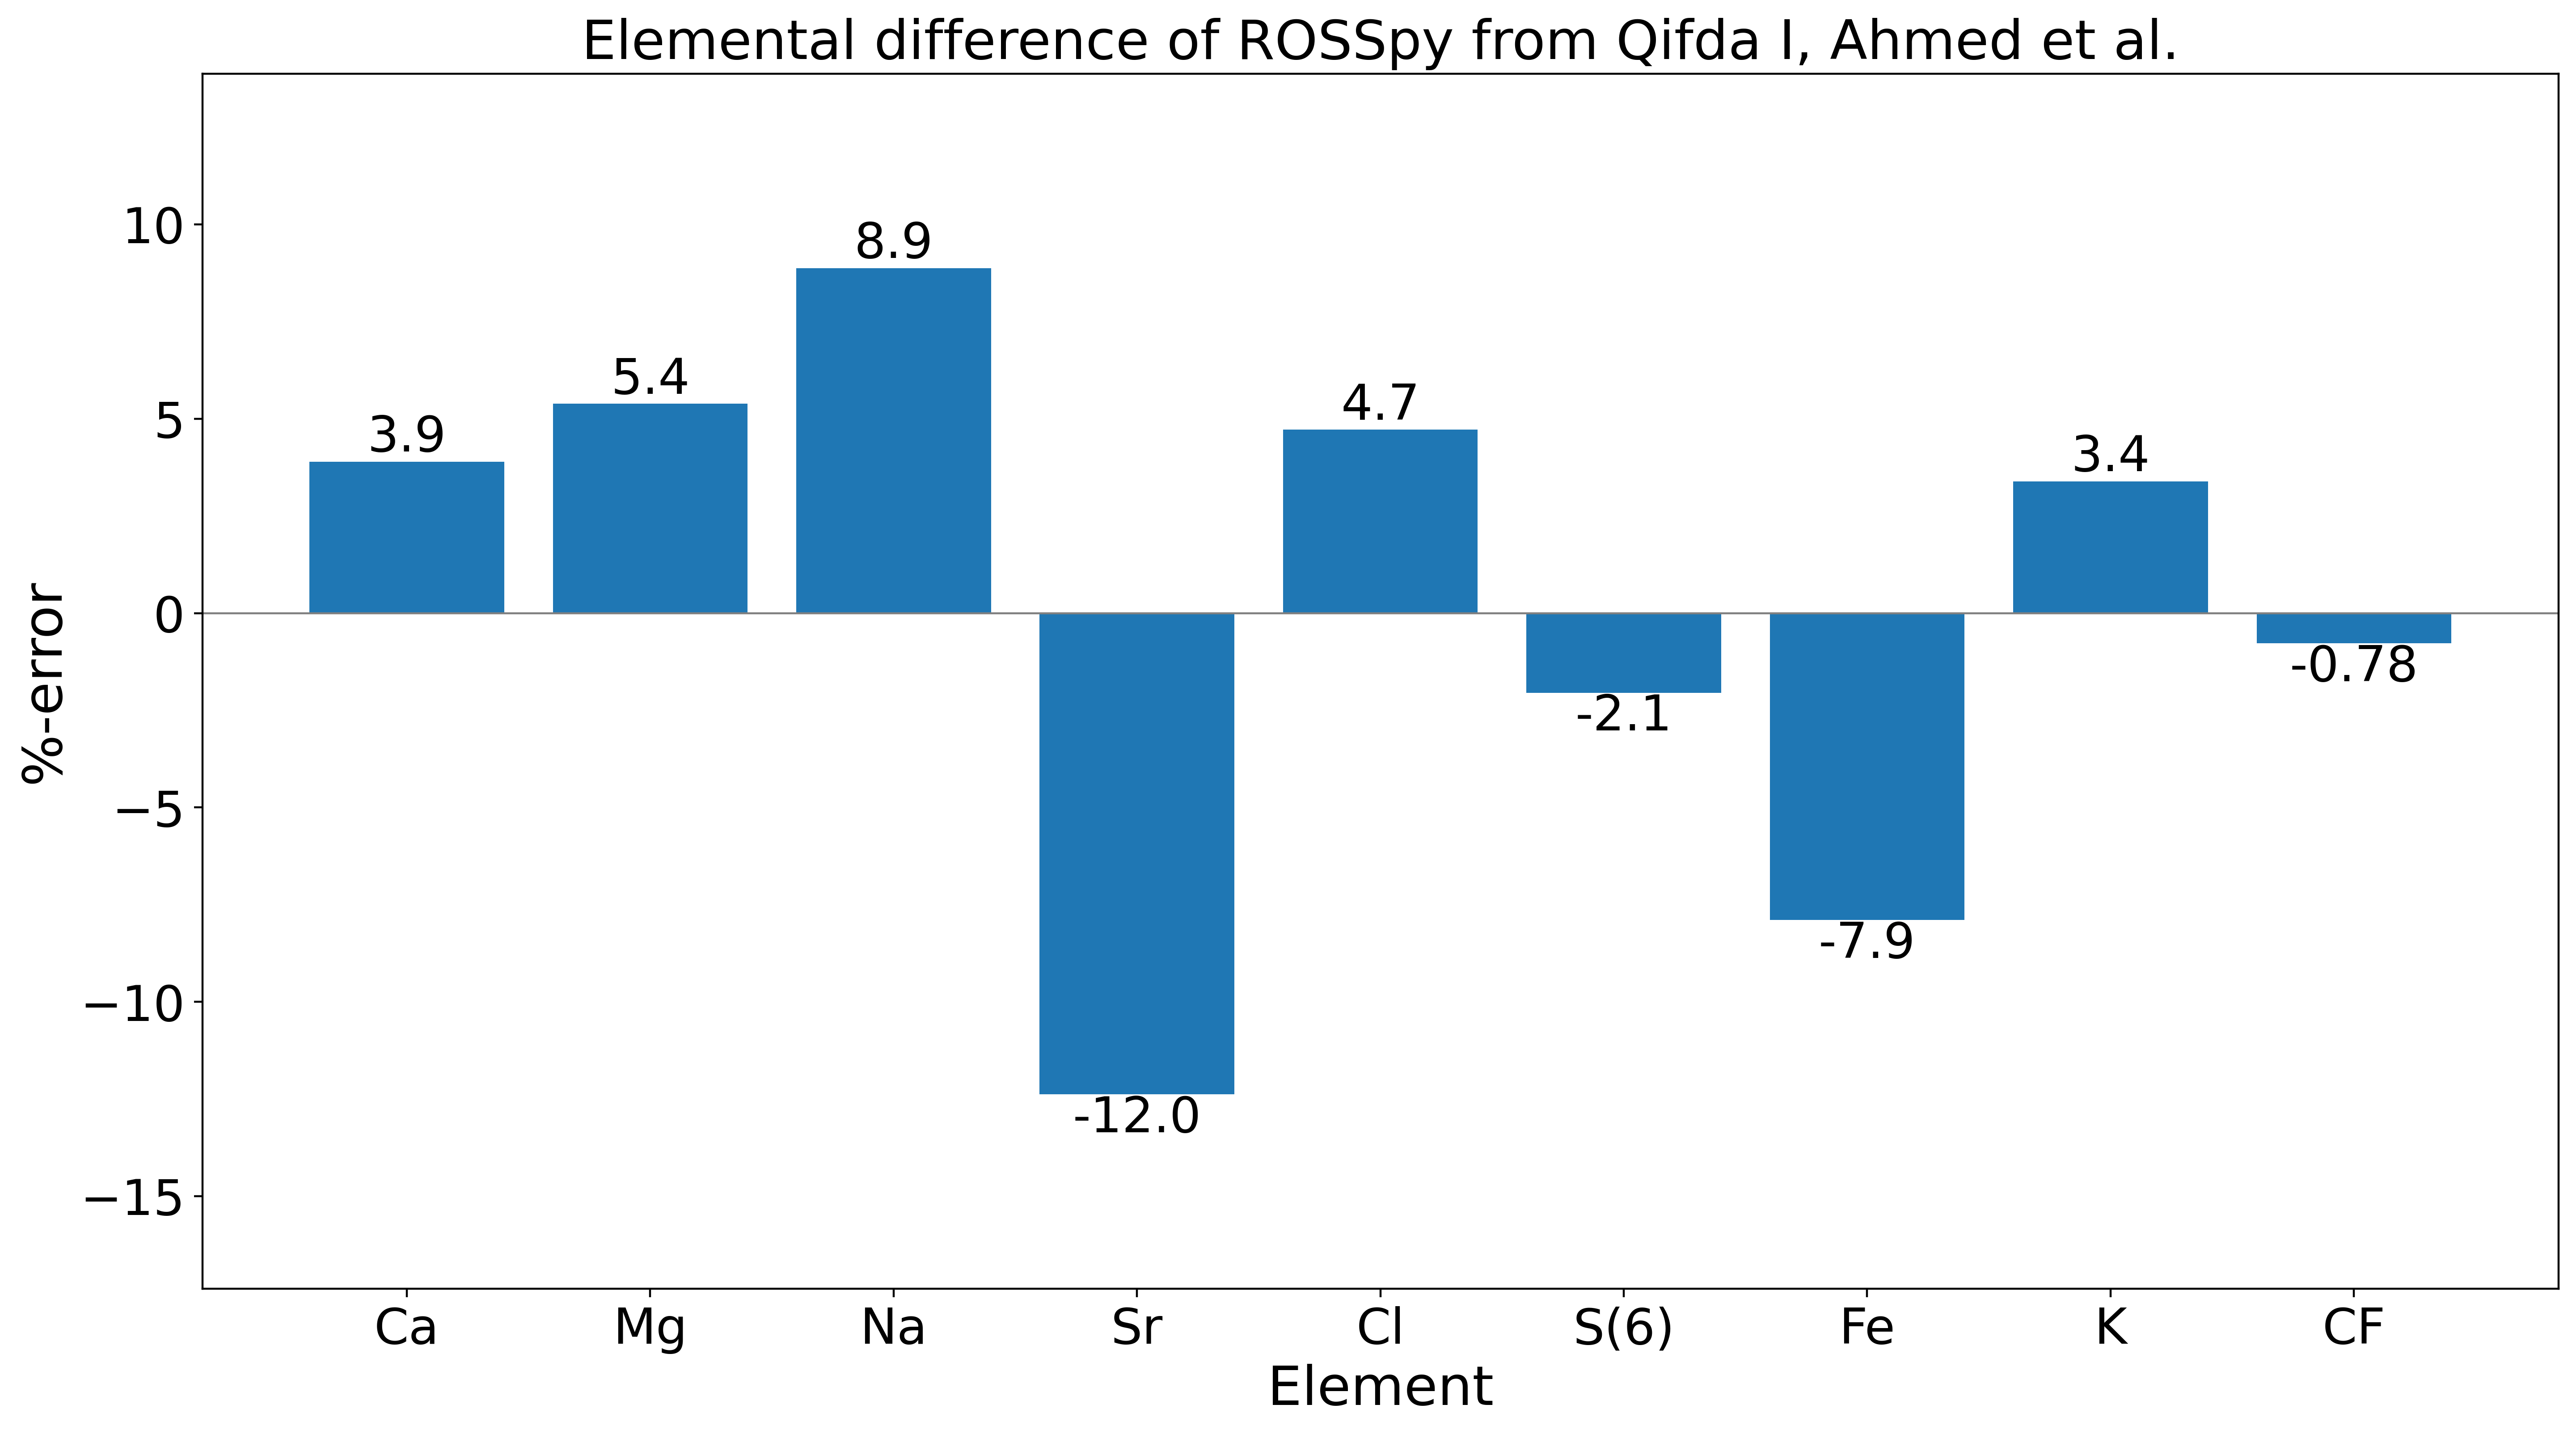

In [5]:
%run ../../../rosspy/ro.py
simulation_perspective = 'all_distance'
simulation_name = 'improved_ionic_concentrations_over_distance'

# create the input file
ross = ROSSPkg(database_selection, simulation, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name, export_format="eps")

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Ahmed_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, elemental_masses, literature_cf, False)